# Постановка задачи

Необходимо разработать прогноз продаж для туроператора, продающего туры в Объединенные Арабские Эмираты с помощью статистических методов.

**Дано:**
-	Туроператор «ОАЭ Тур» продает туры в ОАЭ на своем сайте;
-	Единственным каналом продвижения является SEO в Яндексе. Единственным поисковым запросом, по которому оптимизирован сайт, является «туры в оаэ»;
-	У «ОАЭ Тур» есть только один конкурент;
-	Основной фактор конкуренции – это цена;
-	Имеется статистика по средним ценам ну тур у «ОАЭ Тур» и конкурента, а также количеству заказов «ОАЭ Тур», в недельном разрезе;


# Решение

Решать задачу будем моделью регрессии. С временными рядами работать тяжело, а прогнозировать еще тяжелее. Модели класса ARIMA использовать не будем.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
%matplotlib inline

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 1) Анализ начальных данных

#### Чтение данных

In [2]:
# Создаем генератор строк
def generator_of_rows(filename):
    '''
    Generator of rows in csv file
    Returns row per call.
    
    '''
    # Открываем файл
    with open(filename, "r") as csvfile:
        datareader = csv.reader(csvfile)
        for row in datareader:
            yield row

In [3]:
def generate_start_data(filename):
    '''
    Return raw data from csv.
    
    Args:
        filename:str
            "*.csv" like format
    '''
    
    week = []
    own_price = []
    competitor_price = []
    sales = []
    week_index = 0
    for row in generator_of_rows('data.csv'):
        week_data = (row[0].split(';'))

        week.append(week_index)
        own_price.append(float(week_data[0]))
        competitor_price.append(float(week_data[1]))

        if week_data[2]:
            sales.append(float(week_data[2]))
        else:
            sales.append(None)

        week_index+=1
        
    data = pd.DataFrame()
    data['week'] = week
    data.index = data['week']
#     data.drop(columns=['week'], inplace=True)
    data['own_price'] = own_price
    data['competitor_price'] = competitor_price
    data['sales'] = sales
    
    return data
start_data = generate_start_data('data.csv')

Статистика собранна по неделям. 

Имеются признаки и таргет за 42 недели, необходимо восстановить таргет на оставшиеся 10 недель года.

**Накопленная статистика**

In [4]:
start_data.head()

,week,own_price,competitor_price,sales
week,,,,
0,0,103197.80,125185.20,110.0
1,1,107808.30,111489.70,91.0
2,2,92518.58,98027.54,93.0
3,3,80068.75,98274.79,104.0
4,4,97560.45,128452.00,117.0


**Данные для прогноза**

In [5]:
start_data.tail(11)

,week,own_price,competitor_price,sales
week,,,,
41,41,99600.50,111304.50,125.0
42,42,106651.70,96013.79,NaN
43,43,101673.50,102984.40,NaN
44,44,123099.70,103358.10,NaN
45,45,119102.70,125948.50,NaN
46,46,101896.10,91143.04,NaN
47,47,124413.50,107045.30,NaN
48,48,125538.70,110561.70,NaN
49,49,111693.30,110301.80,NaN


**Корреляционная матрица**

In [6]:
start_data.corr()

,week,own_price,competitor_price,sales
week,1.000000,0.389978,0.148848,0.160546
own_price,0.389978,1.000000,0.483572,-0.036660
competitor_price,0.148848,0.483572,1.000000,0.599328
sales,0.160546,-0.036660,0.599328,1.000000


Первичный анализ данных свидетельствует о сильной корреляции **Цены путевки у конкурента** и **Количества продаж**.

Вполне закономерный факт, чем выше цена у конкурента, тем больше клиентов придет за путевкой к нам.

### 2) Визуальный анализ. Временной ряд продаж

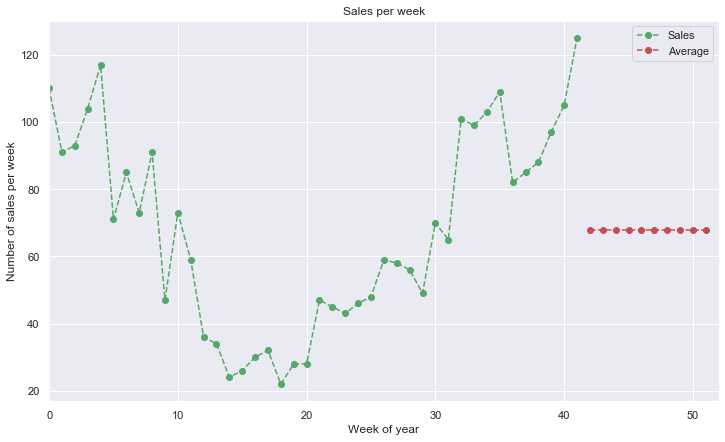

In [7]:
plt.figure(figsize = (12,7))
plt.plot(start_data.index, start_data.sales,'go--', label='Sales')
plt.plot(start_data.index[42:], start_data.sales[42:].fillna(start_data.sales.mean()),'ro--', label='Average')
plt.ylabel('Number of sales per week')
plt.xlim(0,52)
plt.xlabel('Week of year')
plt.title('Sales per week')
plt.legend()
plt.show()

Визуально видно, что ряд не является стационарным, есть сильная зависимость от сезона. Тем не менее, применение модели **SARIMAX** в данном случае не приведет к достойным результатам: данных очень мало => извлечь сезонность и тренд по 40 точкам очень сложно. 

Вместо этого используем модели регрессии. 

(Хотя можно было бы попробовать построить ARIMA и передать прогнозы в модель регрессии)

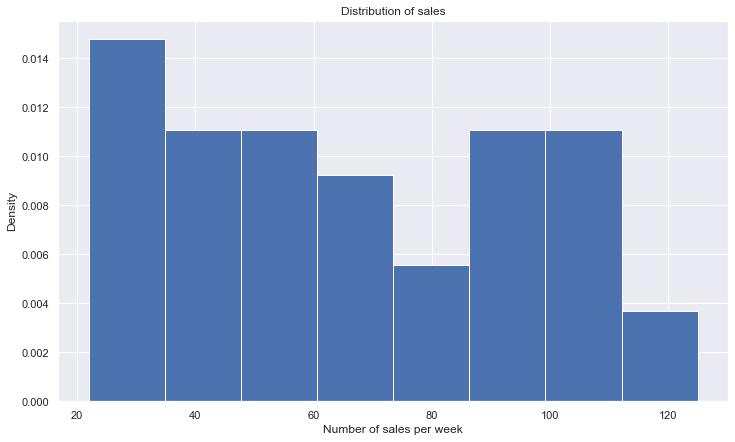

In [8]:
plt.figure(figsize = (12,7))
plt.hist(start_data.sales, density=True, bins=8)
plt.xlabel('Number of sales per week')
plt.ylabel('Density')
plt.title('Distribution of sales')
plt.show()

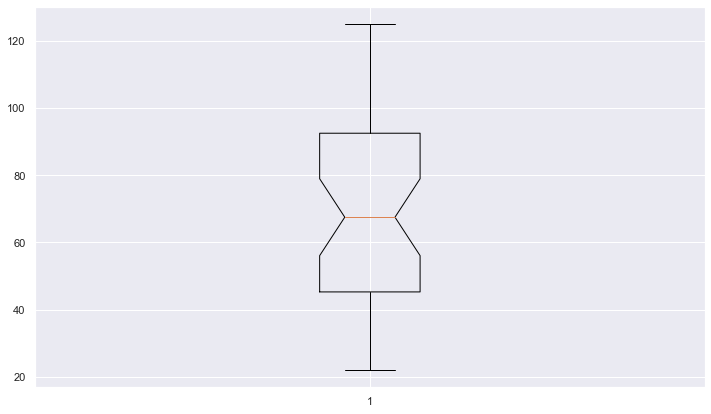

In [9]:
plt.figure(figsize = (12,7))
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(start_data.sales.values[:42], notch=True)
plt.show()

По гистограмме можно сказать, что распределение средней цены на тур **далеко от нормального** (Критерий Шапиро-Уилкадолжен это подтвердить). Что объясняется **малым объемом данных, шумом и сложной зависимостью продаж от сезона**.

### 3) Генерация новых признаков.

Можно было бы использовать номер недели в году в качестве признака в модели регрессии, но расстояние между 1-й неделей и 52-й очень большое, тогда как в жизни это две соседние недели в году. 

Преобразуем номер недели с помощью тригонометрической функции:

$\sin (week)=|\sin \left( \frac{\pi }{52}\cdot n\_week \right)|$ 

In [10]:
data = start_data.copy()
data.insert(0,'sin(week)',abs(np.sin(start_data.index*np.pi/52)))

Теперь 52-я и 1-я неделя близки.

In [11]:
data.iloc[[0,51]]

,sin(week),week,own_price,competitor_price,sales
week,,,,,
0,0.000000,0,103197.80,125185.2,110.0
51,0.060378,51,85283.17,103556.0,NaN


Так же добавим следующие признаки:
- разница цен конкурента и нашей
- разница цен нормированная на нашу цену
- количество продаж на прошлой неделе
- среднее/максимальное/минимальное/медиана/дисперсия числа продаж за прошлые 4 недели
- выручка за прошлую неделю (продажи * среднюю цену)
- среднее/максимальное/минимальное/медиана/дисперсия выручки за прошлые 4 недели
- разница выручки туроператоров за прошлую неделю (при условии равенства продаж)
- среднее/максимальное/минимальное/медиана/дисперсия разницы выручки за прошлые 4 недели

In [12]:
data.insert(4,'abs_delta', data['competitor_price'] - data['own_price'])
data.insert(4,'fraction_delta', data['abs_delta'] / data['own_price'])

In [13]:
names_of_functions = ['mean_','max_','min_','median_','std_']
functions = [np.mean, np.max, np.min, np.median, np.std]

In [14]:
prev_sales = [0]
prev_revenue = [0]
delta_prev_revenue = [0]

sales_features = []
revenue_features = []
delta_revenue_features = []
for i in range(len(data)):
    
    last_4sales = []
    last_4revenue = []
    last_delta_revenue = []
    
    if i-1>=0:
        prev_sales.append(data['sales'].loc[i-1])
        prev_revenue.append(data['sales'].loc[i-1]*data['own_price'].loc[i-1])
        delta_prev_revenue.append(data['sales'].loc[i-1]*(data['competitor_price'].loc[i-1] - data['own_price'].loc[i-1]))
    if i-4>=0:
        last_4sales = [data['sales'].loc[i-j] for j in range(1,5)]
        last_4revenue = [data['sales'].loc[i-j]*data['own_price'].loc[i-j] for j in range(1,5)]
        last_delta_revenue = [data['sales'].loc[i-j]*(data['competitor_price'].loc[i-j] - data['own_price'].loc[i-j]) for j in range(1,5)]
    elif i>0:
        last_4sales = [data['sales'].loc[i-j] for j in range(1,i)]
        last_4revenue = [data['sales'].loc[i-j]*data['own_price'].loc[i-j] for j in range(1,i)]
        last_delta_revenue = [data['sales'].loc[i-j]*(data['competitor_price'].loc[i-j] - data['own_price'].loc[i-j]) for j in range(1,i)]
    
    if len(last_4sales)>0:
        sales_features.append([function(last_4sales) for function in functions])
        revenue_features.append([function(last_4revenue) for function in functions])
        delta_revenue_features.append([function(last_delta_revenue) for function in functions])
    else:
        empty = [0,0,0,0]
        sales_features.append([function(empty) for function in functions])
        revenue_features.append([function(empty) for function in functions])
        delta_revenue_features.append([function(empty) for function in functions])

data.insert(4,'prev_sales', prev_sales)
data.insert(4,'prev_revenue', prev_revenue)
data.insert(4,'prev_delta_revenue', delta_prev_revenue)

In [15]:
column_names = []
feature_names = ['sales_4week', 'revenue_4week', 'delta_revenue_4week']
features = [sales_features, revenue_features, delta_revenue_features]
ind_col=0
for feature_name, feature in zip(feature_names, features):
    for ind_name, function_name in enumerate(names_of_functions):
        column_name = function_name+feature_name
        column_names.append(column_name)
        
#         data[column_name] = np.array(feature)[:,ind_name]
        data.insert(4+ind_col, column_name, np.array(feature)[:,ind_name])
        ind_col+=1

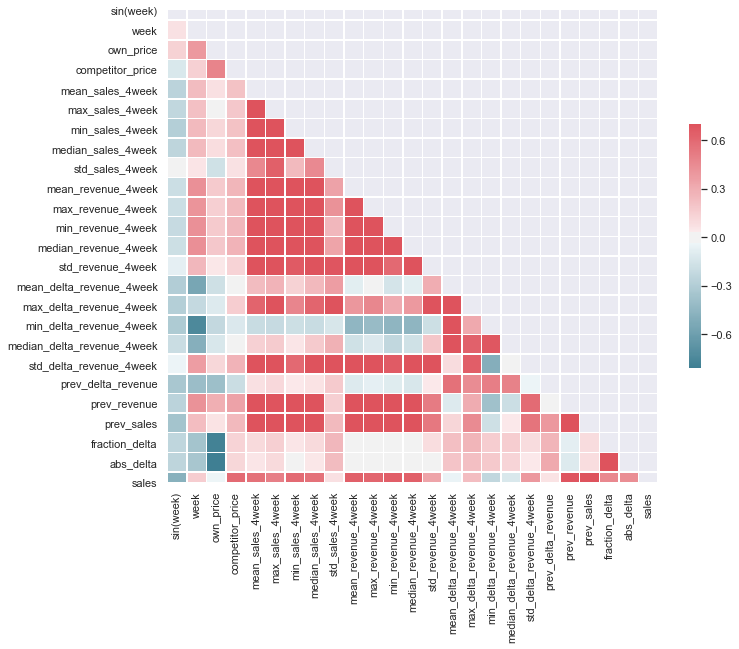

In [16]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [17]:
data.corr().sales

sin(week)                    -0.485106
week                          0.160546
own_price                    -0.036660
competitor_price              0.599328
mean_sales_4week              0.565840
max_sales_4week               0.504999
min_sales_4week               0.593743
median_sales_4week            0.568227
std_sales_4week               0.075533
mean_revenue_4week            0.637045
max_revenue_4week             0.615553
min_revenue_4week             0.650116
median_revenue_4week          0.635425
std_revenue_4week             0.342504
mean_delta_revenue_4week     -0.049251
max_delta_revenue_4week       0.228386
min_delta_revenue_4week      -0.227279
median_delta_revenue_4week   -0.124122
std_delta_revenue_4week       0.395354
prev_delta_revenue            0.063766
prev_revenue                  0.683272
prev_sales                    0.696313
fraction_delta                0.468243
abs_delta                     0.437446
sales                         1.000000
Name: sales, dtype: float

Сгенерированные признаки хорошо коррелируют с таргетом, однако необходимо в любом случае провести **feature selection**

### 4) Построение скользящего окна

Для валидации модели будем использовать скользящее окно. Предсказывать будем продажи на следующей неделе.  
Обучать модель будем на окне с переменной шириной, каждый раз добавляя новый объект после валидации.
В качестве метрики будем использовать **коэффициент детерминации**

In [18]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

In [19]:
data_train = data[:42].copy()
data_test = data[42:].copy()

Сначала найдем наулучшее значение начальной ширины **растущего окна**. 

In [20]:
start_gap = 4 
data_train = data[:42].copy()
start_windows = [4*i for i in range(1,9)]
r2_grow_wind = []
for start_window in [4*i for i in range(1,9)]:
    prediction = []
    y_validation = []
    curr_window = start_window
    curr_gap = 4
    for ind_cv in range(len(data_train)-start_window-start_gap):
        curr_data = data_train[curr_gap:curr_gap+curr_window]
        curr_x_train = curr_data.iloc[:,:-1]
        curr_y_train = curr_data.sales
        curr_x_test = data_train.iloc[curr_gap+curr_window,:-1]
        curr_y_valid = data_train.iloc[curr_gap+curr_window,-1]

        rf_reg.fit(curr_x_train,curr_y_train)
        curr_prediction = rf_reg.predict(curr_x_test.values.reshape(1, -1))[0]
        prediction.append(curr_prediction)
        y_validation.append(curr_y_valid)

        curr_window+=1
        
    r2_grow_wind.append(r2_score(y_validation, prediction))
        
    print(f'Начальная ширина окна = {start_window}, R2 = {r2_score(y_validation, prediction)}')

Начальная ширина окна = 4, R2 = 0.6856491133807971
Начальная ширина окна = 8, R2 = 0.7618503532655523
Начальная ширина окна = 12, R2 = 0.7788770036670208
Начальная ширина окна = 16, R2 = 0.6873413885078494
Начальная ширина окна = 20, R2 = 0.5333342103106752
Начальная ширина окна = 24, R2 = 0.27215999441392813
Начальная ширина окна = 28, R2 = -1.8657804776450977
Начальная ширина окна = 32, R2 = -0.4056757318952233


Сравним со скользящим окном **фиксированной ширины**. Из обучения каждый раз удаляем последний объект.

In [21]:
r2_fix_wind = []
for start_window in [4*i for i in range(1,9)]:
    prediction = []
    y_validation = []
    curr_window = start_window
    curr_gap = 4
    for ind_cv in range(len(data_train)-start_window-start_gap):
        curr_data = data_train[curr_gap:curr_gap+curr_window]
        curr_x_train = curr_data.iloc[:,:-1]
        curr_y_train = curr_data.sales
        curr_x_test = data_train.iloc[curr_gap+curr_window,:-1]
        curr_y_valid = data_train.iloc[curr_gap+curr_window,-1]

        rf_reg.fit(curr_x_train,curr_y_train)
        curr_prediction = rf_reg.predict(curr_x_test.values.reshape(1, -1))[0]
        prediction.append(curr_prediction)
        y_validation.append(curr_y_valid)
        
        curr_gap +=1
        
    r2_fix_wind.append(r2_score(y_validation, prediction))
    print(f'Ширина окна = {start_window}, R2 = {r2_score(y_validation, prediction)}')

Ширина окна = 4, R2 = 0.7542172458247388
Ширина окна = 8, R2 = 0.7723721843381501
Ширина окна = 12, R2 = 0.8015779468110629
Ширина окна = 16, R2 = 0.7019735113080792
Ширина окна = 20, R2 = 0.5170236849437049
Ширина окна = 24, R2 = 0.3219081230797879
Ширина окна = 28, R2 = -1.6014766037211885
Ширина окна = 32, R2 = -0.1688882126348228


Сравним окна

In [22]:
pd.DataFrame([r2_fix_wind,r2_grow_wind], columns = ['Ширина_'+str(4*i) for i in range(1,9)], 
             index = ['Fixed_wind','Grow_wind'])

,Ширина_4,Ширина_8,Ширина_12,Ширина_16,Ширина_20,Ширина_24,Ширина_28,Ширина_32
Fixed_wind,0.754217,0.772372,0.801578,0.701974,0.517024,0.321908,-1.601477,-0.168888
Grow_wind,0.685649,0.761850,0.778877,0.687341,0.533334,0.272160,-1.865780,-0.405676


Как видно из таблицы, окно с фиксированной шириной в 12 недель показал лучший результат. 

Таким образом, для построения модели мы будем учитывать данные за последние 12 недель.

In [23]:
prediction = []
y_validation = []
x_validation = []

curr_gap = 4
start_window = 12
curr_window = start_window
for ind_cv in range(len(data_train)-start_window-start_gap):
        curr_data = data_train[curr_gap:curr_gap+curr_window]
        curr_x_train = curr_data.iloc[:,:-1]
        curr_y_train = curr_data.sales
        curr_x_test = data_train.iloc[curr_gap+curr_window,:-1]
        curr_y_valid = data_train.iloc[curr_gap+curr_window,-1]

        rf_reg.fit(curr_x_train,curr_y_train)
        curr_prediction = rf_reg.predict(curr_x_test.values.reshape(1, -1))[0]
        prediction.append(curr_prediction)
        y_validation.append(curr_y_valid)
        x_validation.append(curr_x_test.week)
        
        curr_gap +=1

Построим валидацию и прогноз

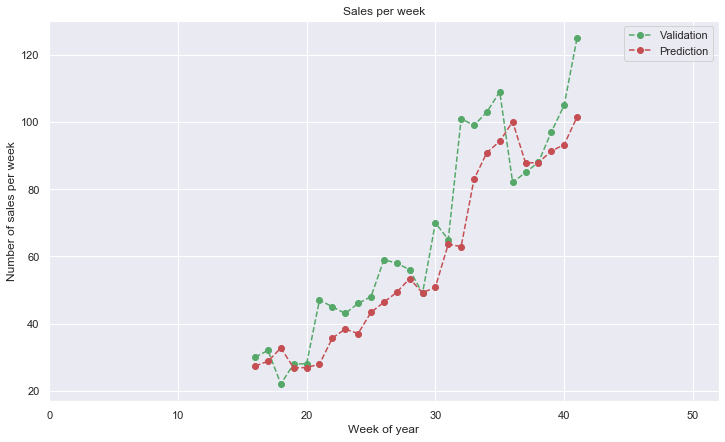

In [24]:
plt.figure(figsize = (12,7))
plt.plot(x_validation, y_validation, 'go--', label='Validation')
plt.plot(x_validation, prediction, 'ro--', label='Prediction')
plt.ylabel('Number of sales per week')
plt.xlim(0,52)
plt.xlabel('Week of year')
plt.title('Sales per week')
plt.legend()
plt.show()

### 5) Предсказание 

In [25]:
def prepare_next_obj(last_data, last_index):
    prev_sales = []
    prev_revenue = []
    delta_prev_revenue = []

    sales_features = []
    revenue_features = []
    delta_revenue_features = []

    last_4sales = []
    last_4revenue = []
    last_delta_revenue = []

    prev_sales = last_data['sales'].iloc[last_index]
    prev_revenue = last_data['sales'].iloc[last_index]*data['own_price'].iloc[last_index]
    delta_prev_revenue = last_data['sales'].iloc[last_index]\
                        *(last_data['competitor_price'].iloc[last_index] - last_data['own_price'].iloc[last_index])

    last_4sales = [last_data['sales'].iloc[last_index-j] for j in range(1,5)]
    last_4revenue = [last_data['sales'].iloc[last_index-j]*last_data['own_price'].loc[last_index-j] for j in range(1,5)]
    last_delta_revenue = [last_data['sales'].iloc[last_index-j]\
                          *(last_data['competitor_price'].iloc[last_index-j] - last_data['own_price'].iloc[last_index-j]) for j in range(1,5)]

    if len(last_4sales)>0:
        sales_features.append([function(last_4sales) for function in functions])
        revenue_features.append([function(last_4revenue) for function in functions])
        delta_revenue_features.append([function(last_delta_revenue) for function in functions])
    
    
    
    
    last_data['prev_sales'].iloc[last_index+1] = prev_sales
    last_data['prev_revenue'].iloc[last_index+1] = prev_revenue
    last_data['prev_delta_revenue'].iloc[last_index+1] = delta_prev_revenue

    feature_names = ['sales_4week', 'revenue_4week', 'delta_revenue_4week']
    features = [sales_features, revenue_features, delta_revenue_features]
    ind_col=0
    for feature_name, feature in zip(feature_names, features):
        for ind_name, function_name in enumerate(names_of_functions):
            column_name = function_name+feature_name
            
            last_data[column_name].iloc[last_index+1] = feature[0][ind_name]
    
    

    return last_data

In [26]:
flow_data = data.copy()
window = 12
curr_start = len(data_train) - window
curr_stop = len(data_train)
for ind_test in range(len(data_test)):
    curr_data = flow_data[curr_start: curr_stop].copy()
    
    curr_x_train = curr_data.iloc[:,:-1]
    curr_y_train = curr_data.sales
    
    curr_x_test = flow_data.iloc[curr_stop,:-1]

    rf_reg.fit(curr_x_train,curr_y_train)
    curr_prediction = rf_reg.predict(curr_x_test.values.reshape(1, -1))[0]
    
    flow_data.sales.iloc[curr_stop] = curr_prediction
    if curr_stop<51:
        flow_data = prepare_next_obj(flow_data, curr_stop)
    
    
    curr_start+=1
    curr_stop+=1
    

### Кривая прогноза

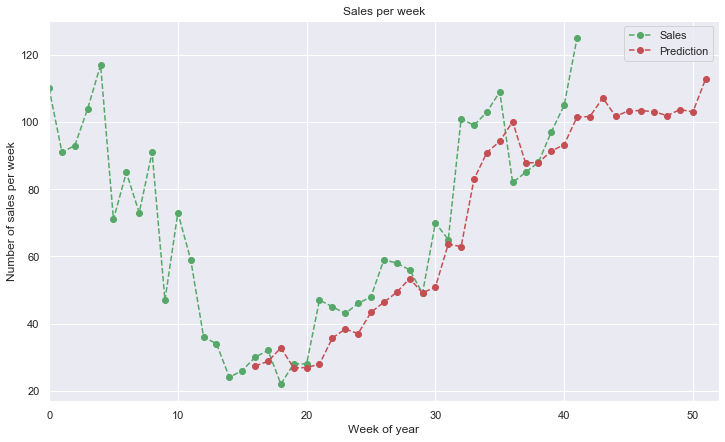

In [27]:
plt.figure(figsize = (12,7))
plt.plot(start_data.index, start_data.sales,'go--', label='Sales')
plt.plot(x_validation+list(flow_data.index[42:]), prediction+list(flow_data.sales[42:]),'ro--', label='Prediction')
plt.ylabel('Number of sales per week')
plt.xlim(0,52)
plt.xlabel('Week of year')
plt.title('Sales per week')
plt.legend()
plt.show()

### 6) Выводы

- Коэффициент детерминации R2 = 0.8 на обучающей выборке
- Данные сложные: сильная сезонная зависимость, большой разброс значений, мало наблюдений
- Сгенерированные признаки сильно коррелируют друг с другом, нужен отбор признаков
- С помощью скользящего окна уменьшается переобучение
- Нужна аккуратная валидация и обучение без заглядывания в будущее

### Что можно улучшить

- Попробовать  другие модели регрессии : Lasso, Ridge, Tree, Gradient Boosting, SARIMA
- Добавить экспоненциальное сглаживание 
- Поиск оптимального окна и валидацию
- Использовать доп.информацию о сезонности в ОАЭ, котировках доллара, стоимости и количество авиаперелетов в ОАЭ, количестве выходных и празничных дней
- Экстримальные новости (засуха, ураган, военный конфликт) 

# Прогноз


In [28]:
flow_data[['own_price', 'competitor_price', 'sales']].loc[42:]

,own_price,competitor_price,sales
week,,,
42,106651.70,96013.79,101.640000
43,101673.50,102984.40,107.172800
44,123099.70,103358.10,101.688784
45,119102.70,125948.50,103.355219
46,101896.10,91143.04,103.417088
47,124413.50,107045.30,103.046846
48,125538.70,110561.70,101.910820
49,111693.30,110301.80,103.728114
50,112086.90,95005.36,103.031086
